# Lorenz Data Assimilation

Run data assimilation experiments on the Lorenz system equations. This notebook will go through running system equations, generating ensembles and implementing ensemble data assimilation algorithms.

In [1]:
from scripts import utilities as utils
from scripts import lorenz_plotting
from scripts import lorenz_array_prep
from scripts import particle_filter as pf
from scripts import ensemble_kalman_filter as enkf

import numpy as np
from pprint import pprint
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

### Define the basic solution to the Lorenz Equations

The following functions define the basic functions for the Lorenz equations

This is the explicit euler solution applied the Lorenz equations, allowing the solution to be run through time

In [2]:
def explicit_euler(quantity, flux, delta):
    """Use the explicit euler approximation to advance one timestep"""

    new_quantity = quantity + flux * delta

    return new_quantity

def predict(u_ini,v_ini,w_ini,du_dt,dv_dt,dw_dt,rho,psi,beta,delta_t):
    """Advance one timestep by applying explicit euler to the state and derivative"""

    #Explicit euler solution of Lorenz equations
    u = explicit_euler(u_ini,du_dt,delta_t)
    v = explicit_euler(v_ini, dv_dt, delta_t)
    w = explicit_euler(w_ini, dw_dt, delta_t)

    #Lorenz equations
    du_dt = rho * (v - u)
    dv_dt = u * (psi - w) - v
    dw_dt = u * v - beta * w

    return u,v,w,du_dt,dv_dt,dw_dt

def run_lorenz_deterministic(rho_array, psi_array, beta_array, u_ini,v_ini,w_ini,t_array,delta_t):
    """Run Lorenz using the predict function to move forward in time"""

    #Initialize variables and arrays
    u = u_ini
    v = v_ini
    w = w_ini
    du_dt = 0
    dv_dt = 0
    dw_dt = 0
    u_array = []
    v_array = []
    w_array = []

    #Loop through time, solving the lorenz equation
    for i, t in enumerate(t_array):

        #Each time through the loop, advance the model one timestep
        u, v, w, du_dt, dv_dt, dw_dt = predict(u,v,w,du_dt,dv_dt,dw_dt,rho_array[i],psi_array[i],beta_array[i],delta_t)

        u_array.append(u)
        v_array.append(v)
        w_array.append(w)

    state_array = np.vstack([u_array,v_array,w_array])

    return state_array



## Define the settings for the base solution

The settings for the lorenz equation and data assimilation are read from the settings.ini file. 

Note that you can update any of the settings in the python code, with for example settings['num_timesteps'] = 100
Start with number of timesteps, and the base variable settings or initial conditions.

In [3]:
settings = utils.read_settings()
pprint(settings)


INFO:root:The run configuration settings have been read from settings.ini


{'beta_base': 2.6666,
 'beta_mod': 2.6666,
 'beta_var': 0.3,
 'delta_t': 0.01,
 'filter_type': True,
 'meas_freq': 1,
 'measurement_var': 0.5,
 'n_eff': 0.7,
 'num_ens': 100,
 'num_timesteps': 1000,
 'psi_base': 28,
 'psi_mod': 25,
 'psi_var': 0.3,
 'resample_option': True,
 'rho_base': 10,
 'rho_mod': 10,
 'rho_var': 0.3,
 'run_enkf': True,
 'run_ensembles': True,
 'run_pf': True,
 'u_h': 1,
 'u_ini_base': -10,
 'u_ini_mod': -10,
 'v_h': 0,
 'v_ini_base': -15,
 'v_ini_mod': -15,
 'w_h': 0,
 'w_ini_base': 10,
 'w_ini_mod': 10}


In [4]:

logging.info('Preparing arrays for initial runs')
t_array                                         = lorenz_array_prep.create_time_array(settings)
rho_base_array, psi_base_array, beta_base_array = lorenz_array_prep.create_parameter_arrays(settings, 'base')
rho_mod_array, psi_mod_array, beta_mod_array    = lorenz_array_prep.create_parameter_arrays(settings, 'mod')


INFO:root:Preparing arrays for initial runs


INFO:root:First performing base model run.
INFO:root:Log test


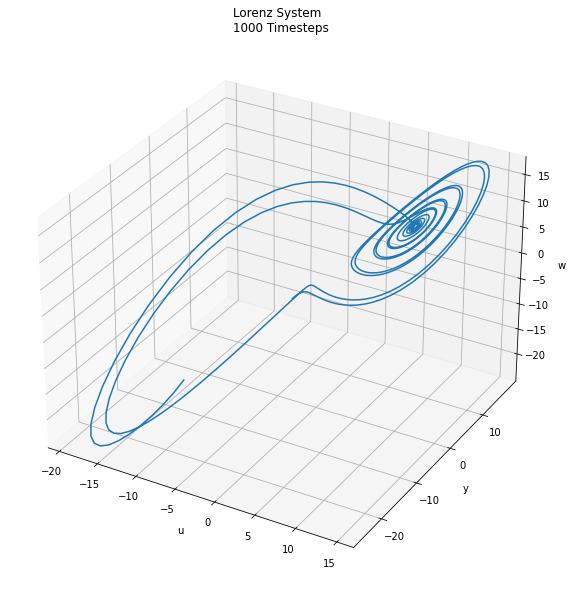

In [5]:
logging.info(f'First performing base model run.')
state_array_base_run = run_lorenz_deterministic(rho_base_array, psi_base_array, beta_base_array,
                                  settings['u_ini_base'],settings['v_ini_base'],settings['w_ini_base'],
                                  t_array, settings['delta_t'])

lorenz_plotting.plot_3D_lorenz(settings,state_array_base_run)

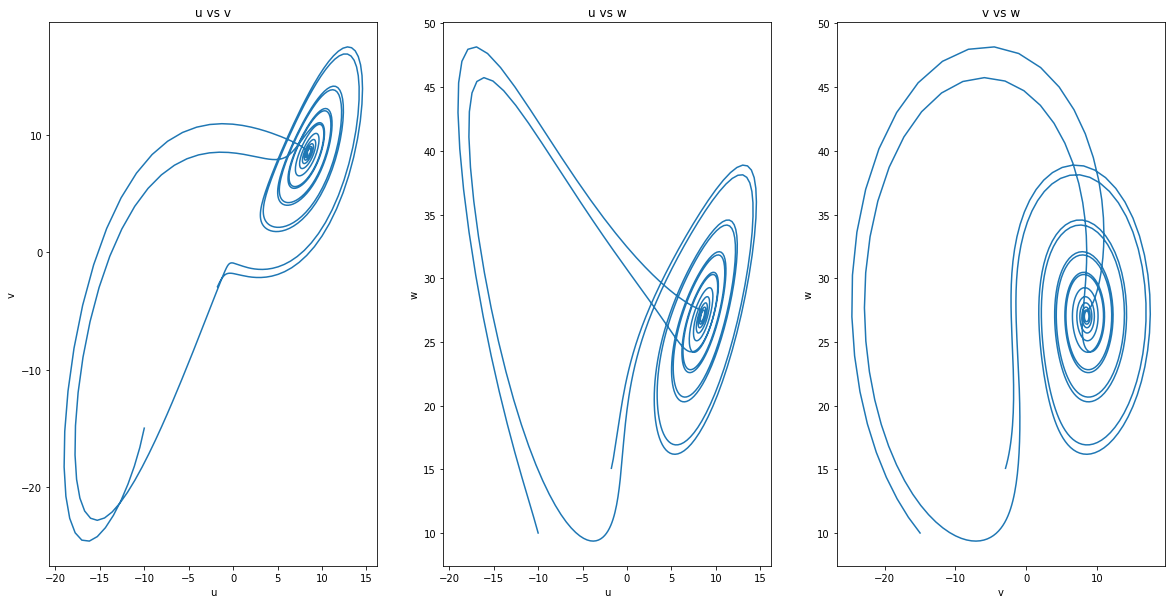

In [6]:
lorenz_plotting.plot_lorenz_basis(state_array_base_run)

### Create Synthetic Measurements from 'Perfect Model'

In [7]:
logging.info('Generating measurements at the desired frequency')
meas_array = lorenz_array_prep.create_measurement_array(settings, state_array_base_run[0][:])

INFO:root:Generating measurements at the desired frequency


### Generate Ensembles

Generate a series of ensembles, by adding a variance to the model parameters

In [8]:
logging.info('Create ensemble of arrays, based on prescribed parameter variance')
rho_ens_array, psi_ens_array, beta_ens_array = lorenz_array_prep.create_ens_arrays(settings)

INFO:root:Create ensemble of arrays, based on prescribed parameter variance


### Run Modified (or 'Actual') Model for Plotting

In [9]:
    logging.info('Second performing modified model run, to be used as pseudo-measurements')
    state_array_mod_run = run_lorenz_deterministic(rho_mod_array, psi_mod_array, beta_mod_array,
                                     settings['u_ini_mod'],settings['v_ini_mod'],settings['w_ini_mod'],
                                     t_array, settings['delta_t'])

INFO:root:Second performing modified model run, to be used as pseudo-measurements


## Define Data Assimilation Loop

The loop below shows the complete data assimilation run. For details on the Particle Filter algorithms, refer the the particle_filter.py

In [10]:
def run_lorenz_ensemble(settings, rho_ens_array, psi_ens_array, beta_ens_array, t_array, da_mode = None):
    """Run the Lorenz model (with options for data assimilation) using an ensemble of different parameter settings"""

    # Initialize values
    u = settings['u_ini_mod']
    v = settings['v_ini_mod']
    w = settings['w_ini_mod']
    du_dt = 0
    dv_dt = 0
    dw_dt = 0

    #Initialize result array
    state_estimate_array = []
    state_result_array = []

    # Initial loop iterates through the timesteps
    for i, t in enumerate(t_array):

        u_ens_array = []
        v_ens_array = []
        w_ens_array = []
        du_ens_array = []
        dv_ens_array = []
        dw_ens_array = []

        # Second loop iterates through ensemble members
        for ens in range(0, settings['num_ens']):

            # For every timestep, except the first,
            # the variables and derivative variables are updated from the previous timestep
            if i > 0:
                u = state_timestep_array[0][ens]
                v = state_timestep_array[1][ens]
                w = state_timestep_array[2][ens]
                du_dt = state_derivative_array[0][ens]
                dv_dt = state_derivative_array[1][ens]
                dw_dt = state_derivative_array[2][ens]

            # Use the predict function to move one timestep forward
            u_new, v_new, w_new, du_dt_new, dv_dt_new, dw_dt_new = predict(u, v, w, du_dt, dv_dt, dw_dt,
                                                                           rho_ens_array[ens], psi_ens_array[ens],
                                                                           beta_ens_array[ens],
                                                                           settings['delta_t'])

            # Append the state and derivative variables to create am array containing each ensemble member
            u_ens_array.append(u_new)
            v_ens_array.append(v_new)
            w_ens_array.append(w_new)
            du_ens_array.append(du_dt_new)
            dv_ens_array.append(dv_dt_new)
            dw_ens_array.append(dw_dt_new)

        # Append the ensemble results for each timestep
        state_timestep_array = np.vstack([u_ens_array, v_ens_array, w_ens_array])
        state_derivative_array = np.vstack([du_ens_array, dv_ens_array, dw_ens_array])



        if da_mode == 'pf':
            """Implement Particle Filter SIS or SIR algorithms. See the particle_filter.py for details"""
            if i == 0:
                logging.info('Running Particle Filter')

            likelihoods      = pf.calculate_likelihoods(settings, state_timestep_array,meas_array[i])
            weights          = pf.calculate_weights(likelihoods)
            state_estimate   = pf.calculate_state_estimate(state_timestep_array, weights)
            effective_weight = pf.calculate_neff(weights)
            n_eff            = settings['n_eff'] * settings['num_ens']

            if settings['resample_option'] == True and n_eff < effective_weight:
                if i == 0:
                    logging.info('Particle Filter with resampling')
                state_timestep_array = pf.resample(settings, state_timestep_array, weights)
                state_estimate = pf.calculate_state_estimate(state_timestep_array, weights)
                # Re-initialize weights for the next run
                weights.fill(1.0 / settings['num_ens'])

        if da_mode == 'enkf':
            """Implement Ensemble Kalman Filter. See ensemble_kalman_filter.py for details"""
            if i == 0:
                logging.info('Running EnKF')
            state_timestep_array, state_estimate = enkf.update_enkf(settings, state_timestep_array, meas_array[i])

        state_estimate_array.append(state_estimate)
        state_result_array.append(state_timestep_array)

    return state_result_array, state_estimate_array

In [11]:
if settings['run_pf'] == True:
    pf_ens_states, pf_est_states = run_lorenz_ensemble(settings, rho_ens_array, psi_ens_array, beta_ens_array,
                                                                   t_array, da_mode = 'pf')

if settings['run_enkf'] == True:
    enkf_ens_states, enkf_est_states = run_lorenz_ensemble(settings, rho_ens_array, psi_ens_array, beta_ens_array,
                                                                   t_array, da_mode = 'enkf')

INFO:root:Running Particle Filter
INFO:root:Particle Filter with resampling
INFO:root:Running EnKF


## Plot Data Assimilation Results

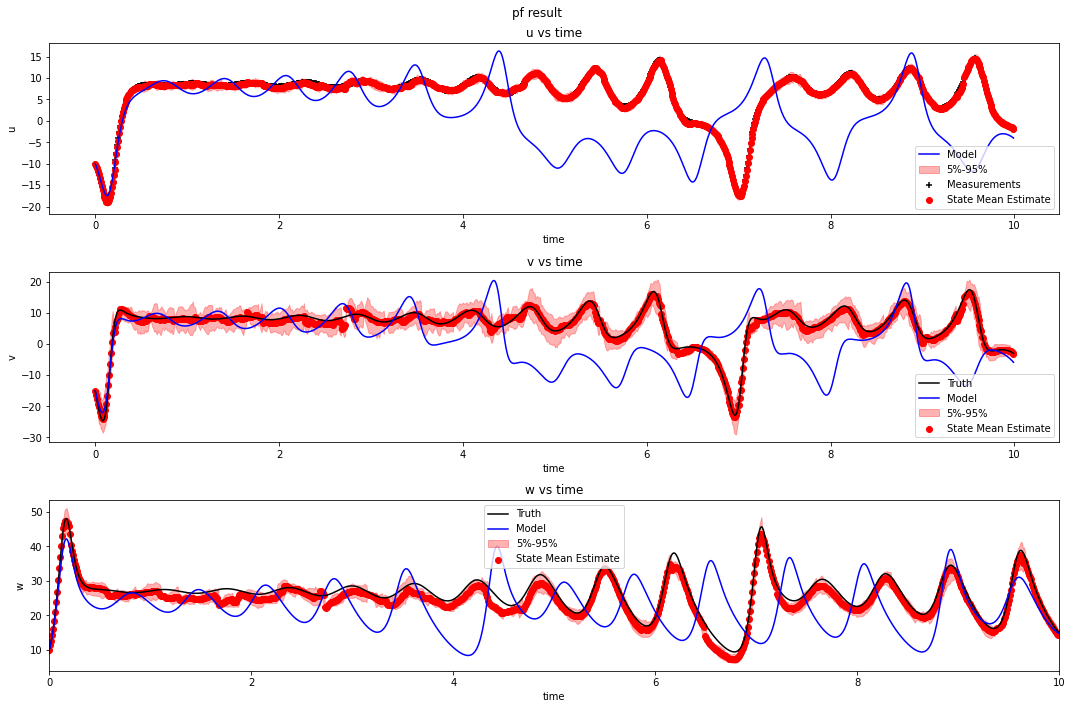

In [12]:
lorenz_plotting.plot_da_result(settings,state_array_base_run,state_array_mod_run,meas_array,
                               pf_ens_states, pf_est_states,t_array,da_mode = 'pf')


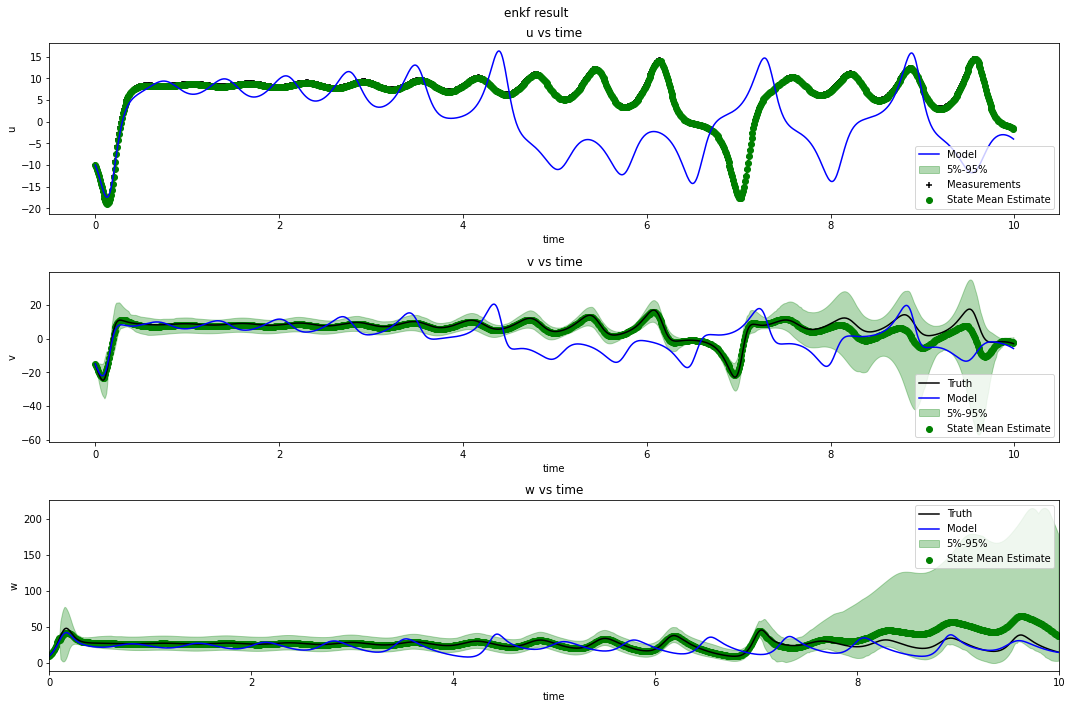

In [13]:
lorenz_plotting.plot_da_result(settings,state_array_base_run,state_array_mod_run,meas_array,
                               enkf_ens_states, enkf_est_states,t_array,da_mode = 'enkf')